In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import os
import sys
from dateutil import parser
from time import time

import imp

%matplotlib inline

import sys
sys.path.append('/home/tony/code/python/notebooks/MyLib/EnsembleMachine')

import date_feature_extractor
imp.reload(date_feature_extractor)
from date_feature_extractor import DateFeatureExtractor

import categorical_feature_extractor
imp.reload(categorical_feature_extractor)
from categorical_feature_extractor import CategoricalFeatureExtraction

import train_test_data_loader
imp.reload(train_test_data_loader)
from train_test_data_loader import TrainTestDataLoader

import feature_selection
imp.reload(feature_selection)
from feature_selection import FeatureSelection

import problem_type
imp.reload(problem_type)
from problem_type import ProblemType

import model_library
imp.reload(model_library)
from model_library import ModelLibrary

#for forward/backward regression
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV

In [7]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.info("logger loaded!")

INFO:root:logger loaded!


In [15]:
#train_df = pd.read_csv('train.csv')
#test_df = pd.read_csv('test.csv')
#store_df = pd.read_csv('store.csv').drop(['PromoInterval'], axis=1, inplace=True)
!pwd

/home/tony/code/python/notebooks/MyLib/EnsembleMachine/data/rossmann


# Loading the data from the file

In [29]:
t0 = time()
dataLoader = TrainTestDataLoader('train_100.csv', 'test_100.csv', train_labels_column='Sales', test_ids_column='Id')
dataLoader.cleanData(max_onehot_limit=200)
X, X_sub, y = dataLoader.getTrainTestData()
print('completed in {0} seconds!'.format(time()-t0))

INFO:train_test_data_loader:reading train file train_100.csv
INFO:train_test_data_loader:reading test file test_100.csv
INFO:train_test_data_loader:extracting train labels from train_df[Sales]
DEBUG:root:processing column: Store of type int64
DEBUG:root:processing column: DayOfWeek of type int64
DEBUG:root:processing column: Date of type object
INFO:root:loading Date as a date
DEBUG:root:processing column: Customers of type int64
DEBUG:root:processing column: Open of type int64
DEBUG:root:processing column: Promo of type int64
DEBUG:root:processing column: StateHoliday of type int64
DEBUG:root:processing column: SchoolHoliday of type int64
INFO:train_test_data_loader:Completed in 0 seconds!


completed in 0.0180580615997 seconds!


In [58]:
model_library = ModelLibrary(is_classification=True, is_binary=False, is_large_scale=False)
model_library.generateModel()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=21, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=340, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
from scipy.stats import randint as sp_randint
from scipy.stats import gamma as sp_gamma

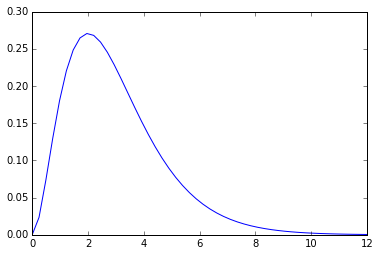

In [51]:
z1 = sp_randint(1, 11)
g1 = sp_gamma(3)
z1.rvs()
g1.rvs()

x = np.linspace(0, np.minimum(g1.dist.b, 12))
h = plt.plot(x, g1.pdf(x))

In [26]:
X.shape, X_sub.shape, y.shape

((100, 11), (100, 11), (100,))

# Selecting features

In [21]:
print "Extracting features"
featureSelection = FeatureSelection(lower_is_better=True, method='all', X=X, y=y, clf=LogisticRegressionCV(), problem_type='classification')

Extracting features


In [23]:
idxs_forwards = [0,2,3,8]
X_forwards, X_sub_forwards = X[:,idxs_forwards], X_sub[:,idxs_forwards]

In [24]:
import feature_selection
imp.reload(feature_selection)
from feature_selection import FeatureSelection

from sklearn.ensemble import RandomForestRegressor
#X_backwards, X_sub_backwards = FeatureSelection.backwards(X, y, X_sub, RandomForestRegressor(n_estimators=10, n_jobs=5), ProblemType.RMSPE, lower_is_better=True, clf_names=dataLoader.train_df.columns)
X_imp, X_sub_imp = FeatureSelection.getFeatureImportanceColumns(X, y, X_sub, RandomForestRegressor(n_estimators=10, n_jobs=5), col_names=dataLoader.train_df.columns, total_importance=0.90)

In [184]:
from random import shuffle

    N = X.shape[1]
    percent = 0.20
    idxs = range(N)
    shuffle(idxs)
    max_idx = int(max(1, np.round(percent*N)))
    idxs[:max_idx]

[0, 10, 3]

In [165]:
from sklearn.cross_validation import train_test_split

rf = RandomForestRegressor(n_jobs=7, n_estimators=20)
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, train_size=0.90)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
ProblemType.RMSPE(y_pred, y_test)

0.19486272021352932

In [155]:
from sklearn.cross_validation import train_test_split

rf = RandomForestRegressor(n_jobs=7, n_estimators=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.90)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
ProblemType.RMSPE(y_pred, y_test)

0.20020303039544898

In [141]:
def submitPreds(filename, y_sub):
    sub_df = pd.read_csv('sample_submission.csv')
    sub_df.Sales = y_sub
    sub_df.to_csv(filename, index=False)
    
y_sub = rf.predict(X_sub_forwards)
submitPreds('first_forwards5_rf20trees__16148.csv', y_sub)

In [154]:
rf.feature_importances_

array([ 0.39010083,  0.01500248,  0.50112696,  0.07976783,  0.01335265,
        0.00064927])

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.90)
rf = RandomForestRegressor(n_jobs=7, n_estimators=10)
rf.fit(X_train, y_train)

In [160]:
tuples = sorted(zip(range(len(rf.feature_importances_)), dataLoader.train_df.columns, rf.feature_importances_), key=lambda x: x[2], reverse=True)
tuples

[(2, 'Open', 0.46035955648582105),
 (0, 'Store', 0.37459639795312716),
 (3, 'Promo', 0.073089276548274074),
 (9, 'Date_dayofyear', 0.028606382392950762),
 (5, 'Date_day', 0.017461663441706535),
 (1, 'DayOfWeek', 0.016110280378141367),
 (8, 'Date_dayofweek', 0.015085839838105741),
 (7, 'Date_year', 0.0049794525869336307),
 (6, 'Date_month', 0.0044617401327617023),
 (4, 'SchoolHoliday', 0.0036706046845585661),
 (10, 'StateHoliday=0', 0.0011192892528948709),
 (11, 'StateHoliday=a', 0.00031582115377476173),
 (12, 'StateHoliday=b', 0.0001367929834621341),
 (13, 'StateHoliday=c', 6.9021674876742197e-06)]

In [161]:
sum_imp, max_imp = 0.0, 0.95
trunc_tuples = []
for idx, col, col_imp in tuples:
    sum_imp += col_imp
    trunc_tuples.append((idx, col, col_imp))
    if sum_imp >= max_imp:
        break
trunc_tuples

[(2, 'Open', 0.46035955648582105),
 (0, 'Store', 0.37459639795312716),
 (3, 'Promo', 0.073089276548274074),
 (9, 'Date_dayofyear', 0.028606382392950762),
 (5, 'Date_day', 0.017461663441706535)]